# DQN for continuous action space


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6128529287827504 -2.576055335275007
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float64, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float64, [None], name='targetQs')
    return states, actions, targetQs

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # nextQs
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob_actions * targetQs) # DPG
    dloss = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    dloss += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    gloss1 = tf.reduce_mean(neg_log_prob_actions)
    gloss2 = tf.reduce_mean(gQs)
    gloss3 = tf.reduce_mean(dQs)
    gloss4 = tf.reduce_mean(targetQs)
    return actions_logits, gQs, gloss, dloss, gloss1, gloss2, gloss3, gloss4

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_loss1, self.g_loss2, self.g_loss3, self.g_loss4 = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [19]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [20]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 100                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [24]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        gloss1_batch, gloss2_batch, gloss3_batch, gloss4_batch = [], [], [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 0.001
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, gloss1, gloss2, gloss3, gloss4, _, _ = sess.run([model.g_loss, model.d_loss,
                                                                           model.g_loss1, model.g_loss2, 
                                                                           model.g_loss3, model.g_loss4,
                                                                           model.g_opt, model.d_opt],
                                                                          feed_dict = {model.states: states, 
                                                                                       model.actions: actions,
                                                                                       model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            gloss1_batch.append(gloss1)
            gloss2_batch.append(gloss2)
            gloss3_batch.append(gloss3)
            gloss4_batch.append(gloss4)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'gloss1-lgP:{:.4f}'.format(np.mean(gloss1_batch)), #-logp
              'gloss2-gQs:{:.4f}'.format(np.mean(gloss2_batch)),#gQs
              'gloss3-dQs:{:.4f}'.format(np.mean(gloss3_batch)),#dQs
              'gloss4-tgtQ:{:.4f}'.format(np.mean(gloss4_batch)),#tgtQs
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.        
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 gloss:0.7406 gloss1-lgP:0.7040 gloss2-gQs:0.0547 gloss3-dQs:0.0371 gloss4-tgtQ:1.0520 dloss:2.0330 exploreP:1.0000
Episode:1 meanR:13.0000 R:12.0000 gloss:0.7648 gloss1-lgP:0.6908 gloss2-gQs:0.1079 gloss3-dQs:0.1134 gloss4-tgtQ:1.1071 dloss:1.9987 exploreP:1.0000
Episode:2 meanR:13.3333 R:14.0000 gloss:0.8047 gloss1-lgP:0.6970 gloss2-gQs:0.1578 gloss3-dQs:0.1975 gloss4-tgtQ:1.1545 dloss:1.9265 exploreP:1.0000
Episode:3 meanR:12.7500 R:11.0000 gloss:0.8301 gloss1-lgP:0.6948 gloss2-gQs:0.2068 gloss3-dQs:0.2743 gloss4-tgtQ:1.1948 dloss:1.8507 exploreP:1.0000
Episode:4 meanR:15.0000 R:24.0000 gloss:0.8791 gloss1-lgP:0.6953 gloss2-gQs:0.2741 gloss3-dQs:0.3807 gloss4-tgtQ:1.2644 dloss:1.8026 exploreP:1.0000
Episode:5 meanR:16.0000 R:21.0000 gloss:0.9418 gloss1-lgP:0.6927 gloss2-gQs:0.3697 gloss3-dQs:0.5267 gloss4-tgtQ:1.3596 dloss:1.7389 exploreP:1.0000
Episode:6 meanR:23.4286 R:68.0000 gloss:1.0930 gloss1-lgP:0.6936 gloss2-gQs:0.5951 gloss3-dQs:0.8574 gloss

Episode:58 meanR:24.5424 R:61.0000 gloss:11.3098 gloss1-lgP:0.6920 gloss2-gQs:16.2244 gloss3-dQs:16.3289 gloss4-tgtQ:16.3446 dloss:18.4676 exploreP:0.9999
Episode:59 meanR:24.9500 R:49.0000 gloss:11.3430 gloss1-lgP:0.6920 gloss2-gQs:16.3582 gloss3-dQs:16.4143 gloss4-tgtQ:16.3914 dloss:20.1985 exploreP:0.9999
Episode:60 meanR:24.9180 R:23.0000 gloss:11.3590 gloss1-lgP:0.6911 gloss2-gQs:16.3871 gloss3-dQs:16.4162 gloss4-tgtQ:16.4350 dloss:19.6122 exploreP:0.9998
Episode:61 meanR:24.7903 R:17.0000 gloss:11.2532 gloss1-lgP:0.6929 gloss2-gQs:16.2938 gloss3-dQs:16.3374 gloss4-tgtQ:16.2402 dloss:21.0882 exploreP:0.9998
Episode:62 meanR:25.2698 R:55.0000 gloss:11.5017 gloss1-lgP:0.6929 gloss2-gQs:16.4838 gloss3-dQs:16.5256 gloss4-tgtQ:16.5986 dloss:17.9273 exploreP:0.9998
Episode:63 meanR:25.2031 R:21.0000 gloss:11.7561 gloss1-lgP:0.6926 gloss2-gQs:16.9075 gloss3-dQs:16.9781 gloss4-tgtQ:16.9748 dloss:19.8079 exploreP:0.9998
Episode:64 meanR:25.0154 R:13.0000 gloss:11.8916 gloss1-lgP:0.6930 glo

Episode:113 meanR:25.9600 R:39.0000 gloss:11.0252 gloss1-lgP:0.6929 gloss2-gQs:15.9479 gloss3-dQs:15.8644 gloss4-tgtQ:15.9127 dloss:12.8804 exploreP:0.9997
Episode:114 meanR:25.9400 R:18.0000 gloss:10.9842 gloss1-lgP:0.6911 gloss2-gQs:15.8090 gloss3-dQs:15.7922 gloss4-tgtQ:15.8946 dloss:11.2723 exploreP:0.9997
Episode:115 meanR:25.8600 R:13.0000 gloss:11.2082 gloss1-lgP:0.6923 gloss2-gQs:16.2758 gloss3-dQs:16.2021 gloss4-tgtQ:16.1915 dloss:12.6632 exploreP:0.9997
Episode:116 meanR:25.7200 R:24.0000 gloss:11.1710 gloss1-lgP:0.6920 gloss2-gQs:16.1763 gloss3-dQs:16.1160 gloss4-tgtQ:16.1442 dloss:12.1288 exploreP:0.9997
Episode:117 meanR:25.5200 R:18.0000 gloss:11.0580 gloss1-lgP:0.6937 gloss2-gQs:16.0650 gloss3-dQs:15.9024 gloss4-tgtQ:15.9412 dloss:11.8119 exploreP:0.9997
Episode:118 meanR:25.4600 R:14.0000 gloss:10.9453 gloss1-lgP:0.6930 gloss2-gQs:15.7522 gloss3-dQs:15.7191 gloss4-tgtQ:15.7941 dloss:11.3052 exploreP:0.9997
Episode:119 meanR:25.5400 R:24.0000 gloss:11.0709 gloss1-lgP:0.6

Episode:167 meanR:23.9700 R:20.0000 gloss:10.7442 gloss1-lgP:0.6926 gloss2-gQs:15.5840 gloss3-dQs:15.4878 gloss4-tgtQ:15.5140 dloss:10.4862 exploreP:0.9996
Episode:168 meanR:24.0700 R:22.0000 gloss:10.6830 gloss1-lgP:0.6929 gloss2-gQs:15.4994 gloss3-dQs:15.3882 gloss4-tgtQ:15.4192 dloss:10.7077 exploreP:0.9996
Episode:169 meanR:23.8600 R:12.0000 gloss:10.4792 gloss1-lgP:0.6920 gloss2-gQs:15.1782 gloss3-dQs:15.1877 gloss4-tgtQ:15.1437 dloss:11.6151 exploreP:0.9996
Episode:170 meanR:23.8700 R:17.0000 gloss:10.5472 gloss1-lgP:0.6919 gloss2-gQs:15.2287 gloss3-dQs:15.2328 gloss4-tgtQ:15.2432 dloss:11.7616 exploreP:0.9996
Episode:171 meanR:23.8700 R:25.0000 gloss:10.4326 gloss1-lgP:0.6937 gloss2-gQs:15.1111 gloss3-dQs:15.0493 gloss4-tgtQ:15.0395 dloss:10.8956 exploreP:0.9996
Episode:172 meanR:23.9300 R:23.0000 gloss:10.5065 gloss1-lgP:0.6925 gloss2-gQs:15.0817 gloss3-dQs:15.0928 gloss4-tgtQ:15.1733 dloss:9.3688 exploreP:0.9996
Episode:173 meanR:24.0300 R:24.0000 gloss:10.6135 gloss1-lgP:0.69

Episode:222 meanR:21.7200 R:23.0000 gloss:10.5807 gloss1-lgP:0.6924 gloss2-gQs:15.2216 gloss3-dQs:15.2481 gloss4-tgtQ:15.2802 dloss:9.6574 exploreP:0.9995
Episode:223 meanR:22.0100 R:44.0000 gloss:10.5704 gloss1-lgP:0.6926 gloss2-gQs:15.2500 gloss3-dQs:15.2575 gloss4-tgtQ:15.2628 dloss:9.6132 exploreP:0.9995
Episode:224 meanR:22.5100 R:63.0000 gloss:10.7250 gloss1-lgP:0.6922 gloss2-gQs:15.4887 gloss3-dQs:15.4897 gloss4-tgtQ:15.4957 dloss:9.2375 exploreP:0.9995
Episode:225 meanR:22.4700 R:13.0000 gloss:10.9287 gloss1-lgP:0.6915 gloss2-gQs:15.6064 gloss3-dQs:15.7799 gloss4-tgtQ:15.8077 dloss:9.8541 exploreP:0.9995
Episode:226 meanR:22.4400 R:13.0000 gloss:11.1418 gloss1-lgP:0.6930 gloss2-gQs:16.0194 gloss3-dQs:16.0588 gloss4-tgtQ:16.0793 dloss:9.0491 exploreP:0.9995
Episode:227 meanR:22.4900 R:21.0000 gloss:11.0996 gloss1-lgP:0.6921 gloss2-gQs:16.0833 gloss3-dQs:16.0694 gloss4-tgtQ:16.0394 dloss:9.8198 exploreP:0.9995
Episode:228 meanR:22.1400 R:15.0000 gloss:11.1448 gloss1-lgP:0.6920 gl

Episode:276 meanR:22.1800 R:14.0000 gloss:10.5075 gloss1-lgP:0.6871 gloss2-gQs:15.2383 gloss3-dQs:15.3046 gloss4-tgtQ:15.2937 dloss:9.0231 exploreP:0.9994
Episode:277 meanR:22.1400 R:20.0000 gloss:10.8410 gloss1-lgP:0.6918 gloss2-gQs:15.5802 gloss3-dQs:15.6511 gloss4-tgtQ:15.6715 dloss:8.0731 exploreP:0.9994
Episode:278 meanR:22.1100 R:17.0000 gloss:10.9050 gloss1-lgP:0.6921 gloss2-gQs:15.6989 gloss3-dQs:15.7912 gloss4-tgtQ:15.7571 dloss:9.3567 exploreP:0.9994
Episode:279 meanR:22.1800 R:17.0000 gloss:10.9269 gloss1-lgP:0.6932 gloss2-gQs:15.8126 gloss3-dQs:15.7420 gloss4-tgtQ:15.7638 dloss:7.4893 exploreP:0.9994
Episode:280 meanR:22.0800 R:22.0000 gloss:10.8097 gloss1-lgP:0.6919 gloss2-gQs:15.6214 gloss3-dQs:15.6667 gloss4-tgtQ:15.6251 dloss:8.8669 exploreP:0.9994
Episode:281 meanR:21.9600 R:12.0000 gloss:10.7674 gloss1-lgP:0.6910 gloss2-gQs:15.5236 gloss3-dQs:15.6113 gloss4-tgtQ:15.5827 dloss:8.5380 exploreP:0.9993
Episode:282 meanR:21.9700 R:16.0000 gloss:10.6825 gloss1-lgP:0.6916 gl

Episode:329 meanR:20.5800 R:15.0000 gloss:10.2367 gloss1-lgP:0.6920 gloss2-gQs:14.7333 gloss3-dQs:14.7743 gloss4-tgtQ:14.7940 dloss:7.1091 exploreP:0.9993
Episode:330 meanR:20.6300 R:25.0000 gloss:10.3639 gloss1-lgP:0.6919 gloss2-gQs:15.0070 gloss3-dQs:14.9935 gloss4-tgtQ:14.9798 dloss:6.4721 exploreP:0.9993
Episode:331 meanR:20.7000 R:30.0000 gloss:10.3696 gloss1-lgP:0.6929 gloss2-gQs:14.9581 gloss3-dQs:14.9866 gloss4-tgtQ:14.9647 dloss:7.0454 exploreP:0.9992
Episode:332 meanR:20.6600 R:10.0000 gloss:10.1075 gloss1-lgP:0.6931 gloss2-gQs:14.6254 gloss3-dQs:14.6075 gloss4-tgtQ:14.5805 dloss:6.6227 exploreP:0.9992
Episode:333 meanR:20.8400 R:29.0000 gloss:10.0684 gloss1-lgP:0.6923 gloss2-gQs:14.5438 gloss3-dQs:14.5301 gloss4-tgtQ:14.5449 dloss:6.8616 exploreP:0.9992
Episode:334 meanR:20.7300 R:20.0000 gloss:10.1448 gloss1-lgP:0.6917 gloss2-gQs:14.6590 gloss3-dQs:14.6972 gloss4-tgtQ:14.6670 dloss:7.9913 exploreP:0.9992
Episode:335 meanR:20.6200 R:19.0000 gloss:9.8401 gloss1-lgP:0.6927 glo

Episode:383 meanR:21.5000 R:12.0000 gloss:10.2456 gloss1-lgP:0.6942 gloss2-gQs:14.8706 gloss3-dQs:14.8392 gloss4-tgtQ:14.7578 dloss:6.5431 exploreP:0.9991
Episode:384 meanR:21.5700 R:18.0000 gloss:9.9407 gloss1-lgP:0.6919 gloss2-gQs:14.3444 gloss3-dQs:14.3913 gloss4-tgtQ:14.3671 dloss:6.4131 exploreP:0.9991
Episode:385 meanR:21.5600 R:14.0000 gloss:10.0603 gloss1-lgP:0.6902 gloss2-gQs:14.5240 gloss3-dQs:14.5444 gloss4-tgtQ:14.5765 dloss:6.1651 exploreP:0.9991
Episode:386 meanR:21.2900 R:10.0000 gloss:10.2649 gloss1-lgP:0.6946 gloss2-gQs:14.8443 gloss3-dQs:14.7400 gloss4-tgtQ:14.7797 dloss:5.7553 exploreP:0.9991
Episode:387 meanR:21.5400 R:45.0000 gloss:9.9349 gloss1-lgP:0.6920 gloss2-gQs:14.4175 gloss3-dQs:14.3627 gloss4-tgtQ:14.3583 dloss:6.0509 exploreP:0.9991
Episode:388 meanR:21.6400 R:33.0000 gloss:9.5329 gloss1-lgP:0.6929 gloss2-gQs:13.8140 gloss3-dQs:13.7623 gloss4-tgtQ:13.7583 dloss:6.1725 exploreP:0.9991
Episode:389 meanR:21.6300 R:12.0000 gloss:9.4411 gloss1-lgP:0.6923 gloss2

Episode:438 meanR:22.6600 R:31.0000 gloss:9.0737 gloss1-lgP:0.6933 gloss2-gQs:13.1296 gloss3-dQs:13.0583 gloss4-tgtQ:13.0873 dloss:5.4482 exploreP:0.9990
Episode:439 meanR:22.4200 R:15.0000 gloss:9.2285 gloss1-lgP:0.6919 gloss2-gQs:13.2841 gloss3-dQs:13.3574 gloss4-tgtQ:13.3377 dloss:5.5688 exploreP:0.9990
Episode:440 meanR:22.3800 R:16.0000 gloss:9.3530 gloss1-lgP:0.6921 gloss2-gQs:13.5021 gloss3-dQs:13.5251 gloss4-tgtQ:13.5134 dloss:5.4651 exploreP:0.9990
Episode:441 meanR:22.4000 R:20.0000 gloss:8.9655 gloss1-lgP:0.6921 gloss2-gQs:12.9402 gloss3-dQs:12.9489 gloss4-tgtQ:12.9532 dloss:5.4157 exploreP:0.9990
Episode:442 meanR:22.4600 R:18.0000 gloss:9.2464 gloss1-lgP:0.6923 gloss2-gQs:13.3669 gloss3-dQs:13.3270 gloss4-tgtQ:13.3575 dloss:5.1330 exploreP:0.9990
Episode:443 meanR:22.5000 R:26.0000 gloss:9.5967 gloss1-lgP:0.6920 gloss2-gQs:13.8574 gloss3-dQs:13.8800 gloss4-tgtQ:13.8702 dloss:4.8949 exploreP:0.9990
Episode:444 meanR:22.3200 R:10.0000 gloss:9.4310 gloss1-lgP:0.6935 gloss2-gQ

Episode:492 meanR:23.0100 R:67.0000 gloss:9.2047 gloss1-lgP:0.6931 gloss2-gQs:13.3014 gloss3-dQs:13.2748 gloss4-tgtQ:13.2800 dloss:4.9293 exploreP:0.9989
Episode:493 meanR:22.8400 R:17.0000 gloss:9.3722 gloss1-lgP:0.6922 gloss2-gQs:13.4906 gloss3-dQs:13.5526 gloss4-tgtQ:13.5405 dloss:4.9402 exploreP:0.9989
Episode:494 meanR:22.5700 R:27.0000 gloss:9.3874 gloss1-lgP:0.6925 gloss2-gQs:13.5768 gloss3-dQs:13.5618 gloss4-tgtQ:13.5552 dloss:4.9468 exploreP:0.9989
Episode:495 meanR:22.5000 R:16.0000 gloss:9.2738 gloss1-lgP:0.6928 gloss2-gQs:13.4222 gloss3-dQs:13.3994 gloss4-tgtQ:13.3854 dloss:5.0340 exploreP:0.9989
Episode:496 meanR:22.5100 R:11.0000 gloss:9.0360 gloss1-lgP:0.6911 gloss2-gQs:12.9972 gloss3-dQs:13.0435 gloss4-tgtQ:13.0757 dloss:4.9285 exploreP:0.9989
Episode:497 meanR:22.3600 R:13.0000 gloss:9.1108 gloss1-lgP:0.6926 gloss2-gQs:13.1816 gloss3-dQs:13.1543 gloss4-tgtQ:13.1561 dloss:4.8591 exploreP:0.9989
Episode:498 meanR:22.1100 R:13.0000 gloss:9.2250 gloss1-lgP:0.6911 gloss2-gQ

Episode:546 meanR:22.3700 R:61.0000 gloss:9.4479 gloss1-lgP:0.6914 gloss2-gQs:13.5997 gloss3-dQs:13.6690 gloss4-tgtQ:13.6651 dloss:4.5668 exploreP:0.9988
Episode:547 meanR:22.4000 R:18.0000 gloss:9.7048 gloss1-lgP:0.6949 gloss2-gQs:14.0070 gloss3-dQs:13.9491 gloss4-tgtQ:13.9680 dloss:4.4155 exploreP:0.9988
Episode:548 meanR:22.6300 R:37.0000 gloss:9.4922 gloss1-lgP:0.6918 gloss2-gQs:13.7602 gloss3-dQs:13.7291 gloss4-tgtQ:13.7210 dloss:4.5823 exploreP:0.9988
Episode:549 meanR:22.7500 R:32.0000 gloss:9.3569 gloss1-lgP:0.6928 gloss2-gQs:13.5135 gloss3-dQs:13.5026 gloss4-tgtQ:13.5073 dloss:4.8572 exploreP:0.9988
Episode:550 meanR:22.4600 R:13.0000 gloss:9.3288 gloss1-lgP:0.6921 gloss2-gQs:13.4535 gloss3-dQs:13.4787 gloss4-tgtQ:13.4787 dloss:4.8718 exploreP:0.9988
Episode:551 meanR:22.2500 R:11.0000 gloss:9.6107 gloss1-lgP:0.6921 gloss2-gQs:13.8796 gloss3-dQs:13.8781 gloss4-tgtQ:13.8859 dloss:4.6789 exploreP:0.9988
Episode:552 meanR:22.2400 R:21.0000 gloss:9.2547 gloss1-lgP:0.6919 gloss2-gQ

Episode:600 meanR:22.6600 R:10.0000 gloss:8.9790 gloss1-lgP:0.6930 gloss2-gQs:12.9091 gloss3-dQs:12.9431 gloss4-tgtQ:12.9560 dloss:4.3594 exploreP:0.9986
Episode:601 meanR:22.6600 R:10.0000 gloss:9.0481 gloss1-lgP:0.6924 gloss2-gQs:13.0157 gloss3-dQs:13.0587 gloss4-tgtQ:13.0689 dloss:4.6798 exploreP:0.9986
Episode:602 meanR:22.8700 R:33.0000 gloss:9.0462 gloss1-lgP:0.6931 gloss2-gQs:13.0537 gloss3-dQs:13.0627 gloss4-tgtQ:13.0514 dloss:4.3334 exploreP:0.9986
Episode:603 meanR:22.8500 R:28.0000 gloss:9.0398 gloss1-lgP:0.6926 gloss2-gQs:13.0331 gloss3-dQs:13.0601 gloss4-tgtQ:13.0522 dloss:4.2456 exploreP:0.9986
Episode:604 meanR:22.8600 R:24.0000 gloss:9.1850 gloss1-lgP:0.6929 gloss2-gQs:13.1958 gloss3-dQs:13.2498 gloss4-tgtQ:13.2564 dloss:4.4284 exploreP:0.9986
Episode:605 meanR:22.7400 R:16.0000 gloss:8.9776 gloss1-lgP:0.6936 gloss2-gQs:13.0267 gloss3-dQs:12.9521 gloss4-tgtQ:12.9431 dloss:4.5640 exploreP:0.9986
Episode:606 meanR:22.8400 R:21.0000 gloss:9.2319 gloss1-lgP:0.6922 gloss2-gQ

Episode:658 meanR:22.0200 R:39.0000 gloss:8.7694 gloss1-lgP:0.6921 gloss2-gQs:12.6506 gloss3-dQs:12.6729 gloss4-tgtQ:12.6695 dloss:4.5118 exploreP:0.9985
Episode:659 meanR:22.1700 R:28.0000 gloss:8.9917 gloss1-lgP:0.6929 gloss2-gQs:12.9477 gloss3-dQs:12.9681 gloss4-tgtQ:12.9769 dloss:4.5805 exploreP:0.9985
Episode:660 meanR:22.2500 R:18.0000 gloss:9.1203 gloss1-lgP:0.6933 gloss2-gQs:13.1292 gloss3-dQs:13.1759 gloss4-tgtQ:13.1557 dloss:4.4737 exploreP:0.9985
Episode:661 meanR:22.1800 R:25.0000 gloss:8.9119 gloss1-lgP:0.6928 gloss2-gQs:12.8108 gloss3-dQs:12.8612 gloss4-tgtQ:12.8648 dloss:4.4427 exploreP:0.9985
Episode:662 meanR:22.2200 R:18.0000 gloss:9.3602 gloss1-lgP:0.6926 gloss2-gQs:13.4905 gloss3-dQs:13.5331 gloss4-tgtQ:13.5146 dloss:4.3598 exploreP:0.9985
Episode:663 meanR:22.0900 R:10.0000 gloss:9.4527 gloss1-lgP:0.6902 gloss2-gQs:13.6379 gloss3-dQs:13.6943 gloss4-tgtQ:13.6966 dloss:4.2686 exploreP:0.9985
Episode:664 meanR:22.2200 R:24.0000 gloss:9.5648 gloss1-lgP:0.6919 gloss2-gQ

Episode:715 meanR:21.7900 R:26.0000 gloss:9.0421 gloss1-lgP:0.6931 gloss2-gQs:13.0777 gloss3-dQs:13.0318 gloss4-tgtQ:13.0468 dloss:4.4552 exploreP:0.9984
Episode:716 meanR:21.5100 R:11.0000 gloss:9.0975 gloss1-lgP:0.6923 gloss2-gQs:13.0878 gloss3-dQs:13.1360 gloss4-tgtQ:13.1410 dloss:4.2836 exploreP:0.9984
Episode:717 meanR:21.5700 R:18.0000 gloss:9.0806 gloss1-lgP:0.6933 gloss2-gQs:13.1462 gloss3-dQs:13.1136 gloss4-tgtQ:13.0984 dloss:4.3604 exploreP:0.9984
Episode:718 meanR:21.4200 R:16.0000 gloss:9.1028 gloss1-lgP:0.6932 gloss2-gQs:13.1520 gloss3-dQs:13.1290 gloss4-tgtQ:13.1327 dloss:4.3597 exploreP:0.9984
Episode:719 meanR:21.2000 R:21.0000 gloss:8.9090 gloss1-lgP:0.6930 gloss2-gQs:12.8490 gloss3-dQs:12.8522 gloss4-tgtQ:12.8556 dloss:4.4378 exploreP:0.9984
Episode:720 meanR:21.2300 R:15.0000 gloss:8.9173 gloss1-lgP:0.6933 gloss2-gQs:12.8899 gloss3-dQs:12.8713 gloss4-tgtQ:12.8628 dloss:4.3522 exploreP:0.9984
Episode:721 meanR:21.3000 R:19.0000 gloss:8.9786 gloss1-lgP:0.6928 gloss2-gQ

Episode:770 meanR:21.6500 R:17.0000 gloss:8.4953 gloss1-lgP:0.6917 gloss2-gQs:12.2219 gloss3-dQs:12.2624 gloss4-tgtQ:12.2816 dloss:4.3177 exploreP:0.9983
Episode:771 meanR:21.5300 R:13.0000 gloss:8.5820 gloss1-lgP:0.6924 gloss2-gQs:12.5173 gloss3-dQs:12.4025 gloss4-tgtQ:12.3950 dloss:4.4079 exploreP:0.9983
Episode:772 meanR:21.5100 R:14.0000 gloss:8.8181 gloss1-lgP:0.6926 gloss2-gQs:12.6043 gloss3-dQs:12.7253 gloss4-tgtQ:12.7327 dloss:4.2710 exploreP:0.9983
Episode:773 meanR:21.7800 R:38.0000 gloss:9.0606 gloss1-lgP:0.6930 gloss2-gQs:13.0410 gloss3-dQs:13.0915 gloss4-tgtQ:13.0740 dloss:4.1150 exploreP:0.9983
Episode:774 meanR:21.7300 R:9.0000 gloss:8.9068 gloss1-lgP:0.6924 gloss2-gQs:12.9134 gloss3-dQs:12.8704 gloss4-tgtQ:12.8639 dloss:4.0416 exploreP:0.9983
Episode:775 meanR:21.7300 R:14.0000 gloss:8.7758 gloss1-lgP:0.6930 gloss2-gQs:12.6766 gloss3-dQs:12.6480 gloss4-tgtQ:12.6638 dloss:4.3794 exploreP:0.9983
Episode:776 meanR:21.5500 R:17.0000 gloss:9.0460 gloss1-lgP:0.6930 gloss2-gQs

Episode:824 meanR:22.2000 R:66.0000 gloss:8.7460 gloss1-lgP:0.6927 gloss2-gQs:12.6327 gloss3-dQs:12.6295 gloss4-tgtQ:12.6256 dloss:4.2228 exploreP:0.9982
Episode:825 meanR:22.1200 R:14.0000 gloss:8.7667 gloss1-lgP:0.6921 gloss2-gQs:12.6174 gloss3-dQs:12.6571 gloss4-tgtQ:12.6663 dloss:4.4502 exploreP:0.9982
Episode:826 meanR:22.0500 R:23.0000 gloss:8.6934 gloss1-lgP:0.6933 gloss2-gQs:12.5094 gloss3-dQs:12.5394 gloss4-tgtQ:12.5383 dloss:4.1849 exploreP:0.9982
Episode:827 meanR:21.7400 R:14.0000 gloss:8.9441 gloss1-lgP:0.6923 gloss2-gQs:12.9259 gloss3-dQs:12.9366 gloss4-tgtQ:12.9193 dloss:4.1636 exploreP:0.9982
Episode:828 meanR:21.8200 R:37.0000 gloss:8.8672 gloss1-lgP:0.6922 gloss2-gQs:12.8246 gloss3-dQs:12.8069 gloss4-tgtQ:12.8116 dloss:4.1348 exploreP:0.9981
Episode:829 meanR:22.2000 R:49.0000 gloss:8.9355 gloss1-lgP:0.6929 gloss2-gQs:12.8957 gloss3-dQs:12.8938 gloss4-tgtQ:12.8949 dloss:4.1638 exploreP:0.9981
Episode:830 meanR:22.2400 R:21.0000 gloss:8.9710 gloss1-lgP:0.6934 gloss2-gQ

Episode:880 meanR:24.7200 R:12.0000 gloss:8.8330 gloss1-lgP:0.6920 gloss2-gQs:12.7975 gloss3-dQs:12.7463 gloss4-tgtQ:12.7640 dloss:4.4352 exploreP:0.9980
Episode:881 meanR:24.5900 R:22.0000 gloss:9.0208 gloss1-lgP:0.6925 gloss2-gQs:12.9962 gloss3-dQs:13.0122 gloss4-tgtQ:13.0266 dloss:4.4234 exploreP:0.9980
Episode:882 meanR:24.7800 R:35.0000 gloss:9.2499 gloss1-lgP:0.6934 gloss2-gQs:13.2899 gloss3-dQs:13.3537 gloss4-tgtQ:13.3405 dloss:4.4341 exploreP:0.9980
Episode:883 meanR:24.8200 R:21.0000 gloss:9.2535 gloss1-lgP:0.6928 gloss2-gQs:13.3440 gloss3-dQs:13.3523 gloss4-tgtQ:13.3573 dloss:4.1777 exploreP:0.9980
Episode:884 meanR:24.8800 R:27.0000 gloss:9.2790 gloss1-lgP:0.6914 gloss2-gQs:13.3912 gloss3-dQs:13.4205 gloss4-tgtQ:13.4222 dloss:4.3320 exploreP:0.9980
Episode:885 meanR:24.9000 R:17.0000 gloss:9.2017 gloss1-lgP:0.6927 gloss2-gQs:13.2758 gloss3-dQs:13.2673 gloss4-tgtQ:13.2839 dloss:4.3223 exploreP:0.9980
Episode:886 meanR:24.7400 R:24.0000 gloss:9.6872 gloss1-lgP:0.6923 gloss2-gQ

Episode:934 meanR:23.6300 R:19.0000 gloss:9.2894 gloss1-lgP:0.6932 gloss2-gQs:13.3470 gloss3-dQs:13.4042 gloss4-tgtQ:13.4006 dloss:4.5441 exploreP:0.9979
Episode:935 meanR:23.7600 R:23.0000 gloss:9.3233 gloss1-lgP:0.6925 gloss2-gQs:13.4245 gloss3-dQs:13.4674 gloss4-tgtQ:13.4637 dloss:4.4515 exploreP:0.9979
Episode:936 meanR:23.6700 R:28.0000 gloss:9.3135 gloss1-lgP:0.6933 gloss2-gQs:13.4555 gloss3-dQs:13.4317 gloss4-tgtQ:13.4329 dloss:4.3684 exploreP:0.9979
Episode:937 meanR:23.9100 R:34.0000 gloss:9.2068 gloss1-lgP:0.6931 gloss2-gQs:13.2452 gloss3-dQs:13.2812 gloss4-tgtQ:13.2832 dloss:4.5073 exploreP:0.9979
Episode:938 meanR:23.6700 R:21.0000 gloss:9.4053 gloss1-lgP:0.6927 gloss2-gQs:13.6213 gloss3-dQs:13.5956 gloss4-tgtQ:13.5772 dloss:4.5741 exploreP:0.9979
Episode:939 meanR:23.7700 R:22.0000 gloss:9.2032 gloss1-lgP:0.6925 gloss2-gQs:13.3215 gloss3-dQs:13.2714 gloss4-tgtQ:13.2895 dloss:4.6573 exploreP:0.9979
Episode:940 meanR:23.4900 R:41.0000 gloss:9.1993 gloss1-lgP:0.6926 gloss2-gQ

Episode:989 meanR:25.3700 R:15.0000 gloss:9.6293 gloss1-lgP:0.6942 gloss2-gQs:13.8977 gloss3-dQs:13.8922 gloss4-tgtQ:13.8720 dloss:4.4570 exploreP:0.9978
Episode:990 meanR:25.5400 R:31.0000 gloss:9.8549 gloss1-lgP:0.6920 gloss2-gQs:14.2115 gloss3-dQs:14.2397 gloss4-tgtQ:14.2408 dloss:4.5689 exploreP:0.9978
Episode:991 meanR:25.6100 R:20.0000 gloss:9.6967 gloss1-lgP:0.6917 gloss2-gQs:14.0370 gloss3-dQs:14.0313 gloss4-tgtQ:14.0181 dloss:4.6011 exploreP:0.9978
Episode:992 meanR:25.7700 R:30.0000 gloss:9.7083 gloss1-lgP:0.6917 gloss2-gQs:14.0384 gloss3-dQs:14.0322 gloss4-tgtQ:14.0372 dloss:4.6310 exploreP:0.9978
Episode:993 meanR:25.7500 R:13.0000 gloss:9.8151 gloss1-lgP:0.6926 gloss2-gQs:14.1648 gloss3-dQs:14.1645 gloss4-tgtQ:14.1719 dloss:4.4221 exploreP:0.9977
Episode:994 meanR:25.8500 R:32.0000 gloss:9.5911 gloss1-lgP:0.6927 gloss2-gQs:13.9202 gloss3-dQs:13.8486 gloss4-tgtQ:13.8466 dloss:4.7394 exploreP:0.9977
Episode:995 meanR:25.8300 R:14.0000 gloss:9.3620 gloss1-lgP:0.6924 gloss2-gQ

Episode:1044 meanR:23.6300 R:40.0000 gloss:9.5799 gloss1-lgP:0.6924 gloss2-gQs:13.9064 gloss3-dQs:13.8396 gloss4-tgtQ:13.8361 dloss:4.9569 exploreP:0.9976
Episode:1045 meanR:23.5700 R:21.0000 gloss:9.3725 gloss1-lgP:0.6927 gloss2-gQs:13.5303 gloss3-dQs:13.5105 gloss4-tgtQ:13.5299 dloss:4.9627 exploreP:0.9976
Episode:1046 meanR:23.4900 R:16.0000 gloss:9.2477 gloss1-lgP:0.6913 gloss2-gQs:13.2760 gloss3-dQs:13.3933 gloss4-tgtQ:13.3774 dloss:4.9698 exploreP:0.9976
Episode:1047 meanR:23.3100 R:9.0000 gloss:9.4705 gloss1-lgP:0.6916 gloss2-gQs:13.7283 gloss3-dQs:13.6989 gloss4-tgtQ:13.6932 dloss:5.0892 exploreP:0.9976
Episode:1048 meanR:23.2700 R:16.0000 gloss:9.4355 gloss1-lgP:0.6924 gloss2-gQs:13.6233 gloss3-dQs:13.6147 gloss4-tgtQ:13.6270 dloss:4.9420 exploreP:0.9976
Episode:1049 meanR:23.2500 R:16.0000 gloss:9.3714 gloss1-lgP:0.6934 gloss2-gQs:13.5002 gloss3-dQs:13.5384 gloss4-tgtQ:13.5163 dloss:4.8922 exploreP:0.9976
Episode:1050 meanR:23.1600 R:10.0000 gloss:9.5875 gloss1-lgP:0.6931 glo

Episode:1097 meanR:22.3200 R:93.0000 gloss:9.4483 gloss1-lgP:0.6921 gloss2-gQs:13.6582 gloss3-dQs:13.6505 gloss4-tgtQ:13.6525 dloss:4.7654 exploreP:0.9975
Episode:1098 meanR:22.9200 R:73.0000 gloss:9.7289 gloss1-lgP:0.6923 gloss2-gQs:14.0276 gloss3-dQs:14.0618 gloss4-tgtQ:14.0528 dloss:5.0359 exploreP:0.9975
Episode:1099 meanR:22.9300 R:19.0000 gloss:9.7335 gloss1-lgP:0.6925 gloss2-gQs:14.0654 gloss3-dQs:14.0192 gloss4-tgtQ:14.0548 dloss:4.9186 exploreP:0.9975
Episode:1100 meanR:22.6400 R:11.0000 gloss:9.8104 gloss1-lgP:0.6936 gloss2-gQs:14.2039 gloss3-dQs:14.1725 gloss4-tgtQ:14.1446 dloss:4.8936 exploreP:0.9975
Episode:1101 meanR:22.4500 R:14.0000 gloss:9.5886 gloss1-lgP:0.6926 gloss2-gQs:13.9113 gloss3-dQs:13.8323 gloss4-tgtQ:13.8456 dloss:4.8904 exploreP:0.9975
Episode:1102 meanR:22.4100 R:20.0000 gloss:9.5499 gloss1-lgP:0.6919 gloss2-gQs:13.8097 gloss3-dQs:13.8028 gloss4-tgtQ:13.8024 dloss:5.0456 exploreP:0.9975
Episode:1103 meanR:22.4500 R:15.0000 gloss:9.5739 gloss1-lgP:0.6933 gl

Episode:1152 meanR:22.7100 R:14.0000 gloss:9.4273 gloss1-lgP:0.6921 gloss2-gQs:13.6721 gloss3-dQs:13.6196 gloss4-tgtQ:13.6209 dloss:4.7280 exploreP:0.9974
Episode:1153 meanR:22.4500 R:16.0000 gloss:9.5195 gloss1-lgP:0.6922 gloss2-gQs:13.7175 gloss3-dQs:13.7551 gloss4-tgtQ:13.7531 dloss:4.7179 exploreP:0.9974
Episode:1154 meanR:22.5200 R:25.0000 gloss:9.6808 gloss1-lgP:0.6926 gloss2-gQs:13.9730 gloss3-dQs:13.9832 gloss4-tgtQ:13.9781 dloss:4.8347 exploreP:0.9974
Episode:1155 meanR:22.2700 R:13.0000 gloss:9.6153 gloss1-lgP:0.6922 gloss2-gQs:13.9689 gloss3-dQs:13.8822 gloss4-tgtQ:13.8901 dloss:4.9349 exploreP:0.9974
Episode:1156 meanR:22.2400 R:12.0000 gloss:9.6857 gloss1-lgP:0.6932 gloss2-gQs:13.9890 gloss3-dQs:13.9334 gloss4-tgtQ:13.9731 dloss:4.8955 exploreP:0.9974
Episode:1157 meanR:22.2200 R:9.0000 gloss:9.4506 gloss1-lgP:0.6936 gloss2-gQs:13.6369 gloss3-dQs:13.6405 gloss4-tgtQ:13.6259 dloss:4.7866 exploreP:0.9974
Episode:1158 meanR:22.2000 R:15.0000 gloss:9.5793 gloss1-lgP:0.6928 glo

Episode:1206 meanR:20.1300 R:17.0000 gloss:9.2284 gloss1-lgP:0.6926 gloss2-gQs:13.3170 gloss3-dQs:13.3330 gloss4-tgtQ:13.3233 dloss:4.6734 exploreP:0.9973
Episode:1207 meanR:20.5000 R:49.0000 gloss:9.3071 gloss1-lgP:0.6924 gloss2-gQs:13.4091 gloss3-dQs:13.4397 gloss4-tgtQ:13.4421 dloss:4.6003 exploreP:0.9973
Episode:1208 meanR:20.4100 R:11.0000 gloss:9.2072 gloss1-lgP:0.6908 gloss2-gQs:13.3867 gloss3-dQs:13.3379 gloss4-tgtQ:13.3283 dloss:4.3859 exploreP:0.9973
Episode:1209 meanR:20.7000 R:39.0000 gloss:9.3497 gloss1-lgP:0.6917 gloss2-gQs:13.5108 gloss3-dQs:13.5261 gloss4-tgtQ:13.5172 dloss:4.5971 exploreP:0.9973
Episode:1210 meanR:20.9800 R:40.0000 gloss:9.3592 gloss1-lgP:0.6915 gloss2-gQs:13.5246 gloss3-dQs:13.5338 gloss4-tgtQ:13.5334 dloss:4.6832 exploreP:0.9973
Episode:1211 meanR:20.9600 R:15.0000 gloss:9.7024 gloss1-lgP:0.6926 gloss2-gQs:13.8872 gloss3-dQs:14.0104 gloss4-tgtQ:14.0099 dloss:4.6657 exploreP:0.9973
Episode:1212 meanR:21.0200 R:14.0000 gloss:9.5521 gloss1-lgP:0.6922 gl

Episode:1262 meanR:20.8600 R:35.0000 gloss:9.5250 gloss1-lgP:0.6930 gloss2-gQs:13.7662 gloss3-dQs:13.7599 gloss4-tgtQ:13.7447 dloss:4.6767 exploreP:0.9972
Episode:1263 meanR:20.9300 R:27.0000 gloss:9.5300 gloss1-lgP:0.6918 gloss2-gQs:13.7390 gloss3-dQs:13.7774 gloss4-tgtQ:13.7777 dloss:4.7699 exploreP:0.9972
Episode:1264 meanR:21.0200 R:36.0000 gloss:9.5700 gloss1-lgP:0.6915 gloss2-gQs:13.8425 gloss3-dQs:13.8397 gloss4-tgtQ:13.8411 dloss:4.6889 exploreP:0.9972
Episode:1265 meanR:21.0400 R:17.0000 gloss:9.5133 gloss1-lgP:0.6916 gloss2-gQs:13.7304 gloss3-dQs:13.7666 gloss4-tgtQ:13.7567 dloss:4.9813 exploreP:0.9972
Episode:1266 meanR:21.0600 R:15.0000 gloss:9.7229 gloss1-lgP:0.6933 gloss2-gQs:14.0142 gloss3-dQs:14.0298 gloss4-tgtQ:14.0244 dloss:4.7036 exploreP:0.9972
Episode:1267 meanR:21.1700 R:24.0000 gloss:9.6677 gloss1-lgP:0.6919 gloss2-gQs:13.9958 gloss3-dQs:13.9732 gloss4-tgtQ:13.9723 dloss:4.7905 exploreP:0.9972
Episode:1268 meanR:21.3100 R:33.0000 gloss:9.5900 gloss1-lgP:0.6916 gl

Episode:1316 meanR:22.9600 R:10.0000 gloss:9.4155 gloss1-lgP:0.6925 gloss2-gQs:13.7070 gloss3-dQs:13.5785 gloss4-tgtQ:13.5951 dloss:4.9326 exploreP:0.9970
Episode:1317 meanR:22.9300 R:14.0000 gloss:9.2574 gloss1-lgP:0.6935 gloss2-gQs:13.3557 gloss3-dQs:13.3203 gloss4-tgtQ:13.3486 dloss:4.7016 exploreP:0.9970
Episode:1318 meanR:22.6900 R:16.0000 gloss:9.0664 gloss1-lgP:0.6920 gloss2-gQs:13.1912 gloss3-dQs:13.0989 gloss4-tgtQ:13.1015 dloss:5.1043 exploreP:0.9970
Episode:1319 meanR:22.6100 R:13.0000 gloss:9.2346 gloss1-lgP:0.6922 gloss2-gQs:13.3058 gloss3-dQs:13.3203 gloss4-tgtQ:13.3412 dloss:4.9113 exploreP:0.9970
Episode:1320 meanR:22.5800 R:14.0000 gloss:9.0872 gloss1-lgP:0.6914 gloss2-gQs:13.1480 gloss3-dQs:13.1159 gloss4-tgtQ:13.1435 dloss:4.9435 exploreP:0.9970
Episode:1321 meanR:22.3600 R:31.0000 gloss:9.2078 gloss1-lgP:0.6921 gloss2-gQs:13.3080 gloss3-dQs:13.3087 gloss4-tgtQ:13.3052 dloss:4.7881 exploreP:0.9970
Episode:1322 meanR:22.3800 R:25.0000 gloss:9.3867 gloss1-lgP:0.6925 gl

Episode:1370 meanR:23.1300 R:29.0000 gloss:9.4300 gloss1-lgP:0.6910 gloss2-gQs:13.6744 gloss3-dQs:13.6452 gloss4-tgtQ:13.6473 dloss:4.6698 exploreP:0.9969
Episode:1371 meanR:23.1800 R:19.0000 gloss:9.2270 gloss1-lgP:0.6924 gloss2-gQs:13.3750 gloss3-dQs:13.3048 gloss4-tgtQ:13.3278 dloss:4.5584 exploreP:0.9969
Episode:1372 meanR:22.9800 R:13.0000 gloss:9.1491 gloss1-lgP:0.6913 gloss2-gQs:13.1754 gloss3-dQs:13.2491 gloss4-tgtQ:13.2356 dloss:4.7339 exploreP:0.9969
Episode:1373 meanR:22.8200 R:13.0000 gloss:9.0791 gloss1-lgP:0.6914 gloss2-gQs:13.2207 gloss3-dQs:13.1308 gloss4-tgtQ:13.1292 dloss:4.7133 exploreP:0.9969
Episode:1374 meanR:22.9600 R:34.0000 gloss:9.2886 gloss1-lgP:0.6924 gloss2-gQs:13.3799 gloss3-dQs:13.4108 gloss4-tgtQ:13.4150 dloss:4.6423 exploreP:0.9969
Episode:1375 meanR:22.9300 R:15.0000 gloss:9.2764 gloss1-lgP:0.6926 gloss2-gQs:13.4563 gloss3-dQs:13.3984 gloss4-tgtQ:13.3933 dloss:4.6135 exploreP:0.9969
Episode:1376 meanR:22.4400 R:15.0000 gloss:9.2888 gloss1-lgP:0.6930 gl

Episode:1424 meanR:22.9900 R:38.0000 gloss:9.0780 gloss1-lgP:0.6919 gloss2-gQs:13.1338 gloss3-dQs:13.1067 gloss4-tgtQ:13.1205 dloss:4.5357 exploreP:0.9968
Episode:1425 meanR:23.0900 R:23.0000 gloss:9.1390 gloss1-lgP:0.6926 gloss2-gQs:13.1972 gloss3-dQs:13.1902 gloss4-tgtQ:13.1956 dloss:4.5217 exploreP:0.9968
Episode:1426 meanR:23.2100 R:27.0000 gloss:9.3286 gloss1-lgP:0.6923 gloss2-gQs:13.4779 gloss3-dQs:13.4873 gloss4-tgtQ:13.4738 dloss:4.1835 exploreP:0.9968
Episode:1427 meanR:23.3000 R:26.0000 gloss:9.0978 gloss1-lgP:0.6926 gloss2-gQs:13.1350 gloss3-dQs:13.1339 gloss4-tgtQ:13.1369 dloss:4.3817 exploreP:0.9968
Episode:1428 meanR:23.2300 R:16.0000 gloss:8.9710 gloss1-lgP:0.6934 gloss2-gQs:12.9527 gloss3-dQs:12.9628 gloss4-tgtQ:12.9390 dloss:4.4695 exploreP:0.9968
Episode:1429 meanR:23.2700 R:15.0000 gloss:8.8750 gloss1-lgP:0.6904 gloss2-gQs:12.8442 gloss3-dQs:12.8516 gloss4-tgtQ:12.8545 dloss:4.4952 exploreP:0.9968
Episode:1430 meanR:23.0600 R:10.0000 gloss:9.1137 gloss1-lgP:0.6922 gl

Episode:1477 meanR:23.0800 R:20.0000 gloss:9.1568 gloss1-lgP:0.6921 gloss2-gQs:13.2401 gloss3-dQs:13.2335 gloss4-tgtQ:13.2292 dloss:4.6281 exploreP:0.9967
Episode:1478 meanR:23.1000 R:16.0000 gloss:9.1871 gloss1-lgP:0.6904 gloss2-gQs:13.2899 gloss3-dQs:13.3024 gloss4-tgtQ:13.3069 dloss:4.5128 exploreP:0.9967
Episode:1479 meanR:23.1500 R:13.0000 gloss:9.0268 gloss1-lgP:0.6919 gloss2-gQs:13.0310 gloss3-dQs:13.0581 gloss4-tgtQ:13.0465 dloss:4.7552 exploreP:0.9967
Episode:1480 meanR:23.1400 R:15.0000 gloss:9.3587 gloss1-lgP:0.6912 gloss2-gQs:13.4651 gloss3-dQs:13.5242 gloss4-tgtQ:13.5398 dloss:4.6696 exploreP:0.9967
Episode:1481 meanR:23.1400 R:17.0000 gloss:9.2722 gloss1-lgP:0.6922 gloss2-gQs:13.3555 gloss3-dQs:13.4071 gloss4-tgtQ:13.3944 dloss:4.5741 exploreP:0.9967
Episode:1482 meanR:23.0500 R:17.0000 gloss:9.4624 gloss1-lgP:0.6922 gloss2-gQs:13.7187 gloss3-dQs:13.6818 gloss4-tgtQ:13.6695 dloss:4.5007 exploreP:0.9967
Episode:1483 meanR:22.9500 R:21.0000 gloss:9.4352 gloss1-lgP:0.6927 gl

Episode:1532 meanR:22.0900 R:19.0000 gloss:9.1572 gloss1-lgP:0.6916 gloss2-gQs:13.2853 gloss3-dQs:13.2622 gloss4-tgtQ:13.2410 dloss:4.2716 exploreP:0.9966
Episode:1533 meanR:22.0000 R:11.0000 gloss:9.0298 gloss1-lgP:0.6931 gloss2-gQs:13.0449 gloss3-dQs:13.0240 gloss4-tgtQ:13.0280 dloss:4.6208 exploreP:0.9966
Episode:1534 meanR:21.7300 R:30.0000 gloss:8.7809 gloss1-lgP:0.6906 gloss2-gQs:12.7422 gloss3-dQs:12.7117 gloss4-tgtQ:12.7147 dloss:4.5234 exploreP:0.9966
Episode:1535 meanR:21.5000 R:9.0000 gloss:8.8508 gloss1-lgP:0.6945 gloss2-gQs:12.6422 gloss3-dQs:12.7352 gloss4-tgtQ:12.7435 dloss:4.6535 exploreP:0.9966
Episode:1536 meanR:21.4400 R:16.0000 gloss:8.6725 gloss1-lgP:0.6911 gloss2-gQs:12.5887 gloss3-dQs:12.5509 gloss4-tgtQ:12.5479 dloss:4.6924 exploreP:0.9966
Episode:1537 meanR:21.4500 R:14.0000 gloss:8.9543 gloss1-lgP:0.6912 gloss2-gQs:12.9150 gloss3-dQs:12.9446 gloss4-tgtQ:12.9551 dloss:4.6037 exploreP:0.9966
Episode:1538 meanR:21.6300 R:27.0000 gloss:8.7707 gloss1-lgP:0.6925 glo

Episode:1588 meanR:21.0800 R:20.0000 gloss:8.9168 gloss1-lgP:0.6936 gloss2-gQs:12.8788 gloss3-dQs:12.8463 gloss4-tgtQ:12.8563 dloss:4.2662 exploreP:0.9965
Episode:1589 meanR:21.1100 R:18.0000 gloss:8.8610 gloss1-lgP:0.6929 gloss2-gQs:12.7261 gloss3-dQs:12.7965 gloss4-tgtQ:12.7886 dloss:4.4648 exploreP:0.9965
Episode:1590 meanR:21.1500 R:30.0000 gloss:9.0935 gloss1-lgP:0.6913 gloss2-gQs:13.2049 gloss3-dQs:13.1511 gloss4-tgtQ:13.1533 dloss:4.2482 exploreP:0.9965
Episode:1591 meanR:21.0500 R:21.0000 gloss:8.9832 gloss1-lgP:0.6922 gloss2-gQs:13.0068 gloss3-dQs:12.9653 gloss4-tgtQ:12.9780 dloss:4.0665 exploreP:0.9965
Episode:1592 meanR:21.0700 R:14.0000 gloss:8.7544 gloss1-lgP:0.6931 gloss2-gQs:12.7024 gloss3-dQs:12.6492 gloss4-tgtQ:12.6312 dloss:4.3652 exploreP:0.9964
Episode:1593 meanR:21.0800 R:16.0000 gloss:8.7506 gloss1-lgP:0.6907 gloss2-gQs:12.6498 gloss3-dQs:12.6416 gloss4-tgtQ:12.6678 dloss:4.2739 exploreP:0.9964
Episode:1594 meanR:20.8500 R:13.0000 gloss:8.7967 gloss1-lgP:0.6930 gl

Episode:1642 meanR:21.3200 R:36.0000 gloss:9.1824 gloss1-lgP:0.6922 gloss2-gQs:13.2927 gloss3-dQs:13.2626 gloss4-tgtQ:13.2665 dloss:4.4319 exploreP:0.9963
Episode:1643 meanR:21.4400 R:23.0000 gloss:8.8409 gloss1-lgP:0.6912 gloss2-gQs:12.7301 gloss3-dQs:12.7958 gloss4-tgtQ:12.7907 dloss:4.3200 exploreP:0.9963
Episode:1644 meanR:21.8100 R:49.0000 gloss:9.1647 gloss1-lgP:0.6927 gloss2-gQs:13.2387 gloss3-dQs:13.2336 gloss4-tgtQ:13.2309 dloss:4.4308 exploreP:0.9963
Episode:1645 meanR:21.9500 R:44.0000 gloss:8.9986 gloss1-lgP:0.6923 gloss2-gQs:13.0702 gloss3-dQs:12.9888 gloss4-tgtQ:12.9974 dloss:4.5148 exploreP:0.9963
Episode:1646 meanR:21.9800 R:20.0000 gloss:8.9461 gloss1-lgP:0.6917 gloss2-gQs:12.8882 gloss3-dQs:12.9053 gloss4-tgtQ:12.9348 dloss:4.3170 exploreP:0.9963
Episode:1647 meanR:22.1700 R:33.0000 gloss:8.8629 gloss1-lgP:0.6913 gloss2-gQs:12.8449 gloss3-dQs:12.8279 gloss4-tgtQ:12.8208 dloss:4.4093 exploreP:0.9963
Episode:1648 meanR:22.0600 R:14.0000 gloss:8.7029 gloss1-lgP:0.6913 gl

Episode:1697 meanR:22.8200 R:22.0000 gloss:9.1156 gloss1-lgP:0.6926 gloss2-gQs:13.1465 gloss3-dQs:13.1666 gloss4-tgtQ:13.1616 dloss:4.0252 exploreP:0.9962
Episode:1698 meanR:22.8000 R:12.0000 gloss:9.0102 gloss1-lgP:0.6928 gloss2-gQs:13.0267 gloss3-dQs:13.0082 gloss4-tgtQ:13.0046 dloss:4.2323 exploreP:0.9962
Episode:1699 meanR:22.7500 R:20.0000 gloss:9.0750 gloss1-lgP:0.6930 gloss2-gQs:13.0491 gloss3-dQs:13.1016 gloss4-tgtQ:13.0962 dloss:4.2680 exploreP:0.9962
Episode:1700 meanR:22.6700 R:15.0000 gloss:8.9332 gloss1-lgP:0.6927 gloss2-gQs:12.9714 gloss3-dQs:12.9051 gloss4-tgtQ:12.8957 dloss:4.1712 exploreP:0.9962
Episode:1701 meanR:22.6600 R:27.0000 gloss:8.9642 gloss1-lgP:0.6930 gloss2-gQs:12.9166 gloss3-dQs:12.9318 gloss4-tgtQ:12.9371 dloss:4.1917 exploreP:0.9962
Episode:1702 meanR:23.0800 R:60.0000 gloss:8.9776 gloss1-lgP:0.6922 gloss2-gQs:12.9709 gloss3-dQs:12.9723 gloss4-tgtQ:12.9703 dloss:4.3406 exploreP:0.9962
Episode:1703 meanR:23.0500 R:14.0000 gloss:8.7332 gloss1-lgP:0.6918 gl

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

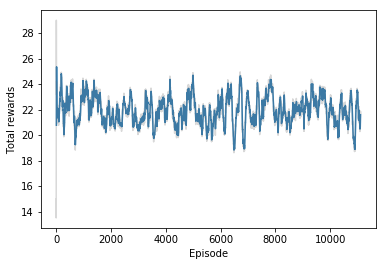

In [33]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

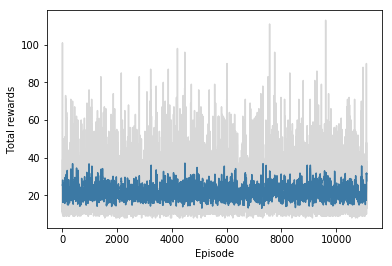

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

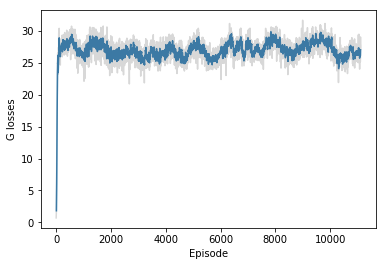

In [35]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

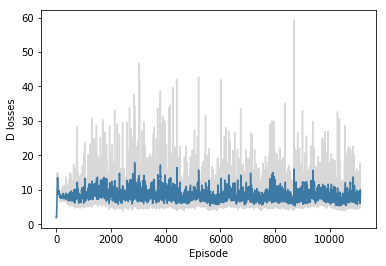

In [36]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.